# **Aprendizaje por Refuerzo: Q-learning**

In [123]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

In [124]:
# Definición del juego:

# Laberinto 2D de 5x5 posiciones:

# S00 S01 S02 S03 S04
# S10 S11 S12 S13 S14
# S20 S21 S22 S23 S24
# S30 S31 S32 S33 S34
# S40 S41 S42 S43 S44

# INICIO: S00
# FINAL:  S44
# POZOS:  S11, S22, S33
# ESTADOS: tuplas de dos elementos. Por ejemplo, (0,0): estado inicial. O (4,4): estado final

# ACCIONES: left, right, up, down
# Recompensas: -1 en general, salvo que caiga en S44 (R=10 y fin=True), o caiga en un pozo (R=-10 y fin=True)

# *******
# *  o  *
# * P   *
# *  P  *
# *   P *
# *    S*
# *******


In [125]:
ACTIONS  = ['left', 'right', 'up', 'down']

### **Modelización del entorno**

In [126]:
SALIDAS = [(4,4)]
POZOS   = [(1,1), (2,2), (3,3)]

POZOS=[(0,1),(1,1),(1,3),(3,1),(3,3),(2,2)]
SALIDAS=[(0,0),(4,0)]

In [127]:
a,b = (1,2)
print(a)
print(b)

1
2


## Clase entorno

In [128]:
class Entorno:
  def __init__(self, n_filas, n_columnas,
               salidas, pozos,
               estado_inicial=(0,0)):
    self.n_filas = n_filas
    self.n_columnas = n_columnas
    self.salidas = salidas.copy()
    self.pozos  = pozos.copy()
    self.S_inicial = estado_inicial
    self.reset()

  def reset(self): # inicializa estado
    self.t = 0
    if self.S_inicial != "random":
      self.S = self.S_inicial
    else: # es random
      estados_no_terminales = []
      for i in range(self.n_filas):
        for j in range(self.n_columnas):
          if ((i,j) not in self.pozos) and ((i,j) not in self.salidas):
            estados_no_terminales.append((i,j))

      indice = np.random.randint(len(estados_no_terminales))
      self.S = estados_no_terminales[indice]

  def display(self):
    aux = np.full((self.n_filas, self.n_columnas), " ")
    aux[self.S[0], self.S[1]] = "o"
    for pozo in self.pozos:
      aux[pozo[0],pozo[1]] = "P"
    for salida in self.salidas:
      aux[salida[0],salida[1]] = "S"
    print(aux)

  def step(self, action):
    fila, col = self.S # fila y columna del estado
    self.t += 1
    reward = -1
    fin = False

    S_new = self.S # salvo que me pueda mover, no me muevo

    # chequeo si me puedo mover:
    if action == "left":
      if col!= 0:
        S_new = (fila, col-1)
    elif action == "right":
      if col!= (self.n_columnas-1):
        S_new = (fila, col+1)
    elif action == "up":
      if fila!= 0:
        S_new = (fila-1, col)
    else: # action == "down"
      if fila!= (self.n_filas-1):
        S_new = (fila+1, col)

    if S_new in self.salidas:
      reward = 10
      fin = True
    elif S_new in self.pozos:
      reward = -10
      fin = True

    self.S = S_new

    return S_new, reward, fin


In [129]:
np.full((5,5), " ")

array([[' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ']], dtype='<U1')

In [130]:
print(SALIDAS)
print(POZOS)

[(0, 0), (4, 0)]
[(0, 1), (1, 1), (1, 3), (3, 1), (3, 3), (2, 2)]


In [131]:
entorno = Entorno(n_filas=5, n_columnas=5,
              salidas=SALIDAS,
              pozos=POZOS,
              #estado_inicial=(2,4)
              estado_inicial="random"
              ) # definir una instancia de la clase Entorno

In [132]:
entorno.display()

[['S' 'P' 'o' ' ' ' ']
 [' ' 'P' ' ' 'P' ' ']
 [' ' ' ' 'P' ' ' ' ']
 [' ' 'P' ' ' 'P' ' ']
 ['S' ' ' ' ' ' ' ' ']]


In [133]:
S_new, reward, fin = entorno.step("left")
print(S_new, reward, fin)
entorno.display()

(0, 1) -10 True
[['S' 'P' ' ' ' ' ' ']
 [' ' 'P' ' ' 'P' ' ']
 [' ' ' ' 'P' ' ' ' ']
 [' ' 'P' ' ' 'P' ' ']
 ['S' ' ' ' ' ' ' ' ']]


### Agente Q-learning

In [134]:
posibles_estados = []
nfilas = 5
ncolumnas = 5
for i in range(nfilas):
  for j in range(ncolumnas):
    posibles_estados.append(str((i,j)))

posibles_estados

['(0, 0)',
 '(0, 1)',
 '(0, 2)',
 '(0, 3)',
 '(0, 4)',
 '(1, 0)',
 '(1, 1)',
 '(1, 2)',
 '(1, 3)',
 '(1, 4)',
 '(2, 0)',
 '(2, 1)',
 '(2, 2)',
 '(2, 3)',
 '(2, 4)',
 '(3, 0)',
 '(3, 1)',
 '(3, 2)',
 '(3, 3)',
 '(3, 4)',
 '(4, 0)',
 '(4, 1)',
 '(4, 2)',
 '(4, 3)',
 '(4, 4)']

In [135]:
posibles_estados = [str((i,j)) for i in range(nfilas) for j in range(ncolumnas)]
posibles_estados

['(0, 0)',
 '(0, 1)',
 '(0, 2)',
 '(0, 3)',
 '(0, 4)',
 '(1, 0)',
 '(1, 1)',
 '(1, 2)',
 '(1, 3)',
 '(1, 4)',
 '(2, 0)',
 '(2, 1)',
 '(2, 2)',
 '(2, 3)',
 '(2, 4)',
 '(3, 0)',
 '(3, 1)',
 '(3, 2)',
 '(3, 3)',
 '(3, 4)',
 '(4, 0)',
 '(4, 1)',
 '(4, 2)',
 '(4, 3)',
 '(4, 4)']

## Clase agente

In [136]:
class QAgent:
  def __init__(self,
               gamma,   # "factor de descuento"
               alpha,   # tasa de aprendizaje
               epsilon, # tasa de exploración
               n_filas, # número de filas del laberinto
               n_columnas, # número de columnas del laberinto
               actions # listado de acciones posibles
               ):
    self.gamma = gamma
    self.alpha = alpha
    self.epsilon = epsilon
    self.n_filas = n_filas
    self.n_columnas = n_columnas
    self.actions = actions.copy()
    self.n_states = n_filas*n_columnas

    posibles_estados = [str((i,j)) for i in range(n_filas) for j in range(n_columnas)]
    self.Q_table = pd.DataFrame(np.zeros((self.n_states, len(actions))),
                                columns=actions, index=posibles_estados)

  def choose_action(self, state):
    if np.random.rand() < self.epsilon: # se explora
      return np.random.choice(self.actions)
    else: # se sigue la tabla Q (acción con mayor valoración)
      valoraciones_acciones = self.Q_table.loc[str(state)]
      if (valoraciones_acciones==0).all():
        return np.random.choice(self.actions)
      else:
        return valoraciones_acciones.idxmax() # columna con mayor valoración

  def update_table(self, S_old, action, S_new, r, fin):
    Q_sa = self.Q_table.loc[str(S_old),action]
    if not fin:
      max_Q_sa_prima = self.Q_table.loc[str(S_new)].max()
      delta_Q_sa = self.alpha*(r+self.gamma*max_Q_sa_prima - Q_sa)
      self.Q_table.loc[str(S_old),action] += delta_Q_sa
    else: # S_new es terminal
      delta_Q_sa = self.alpha*(r - Q_sa)
      self.Q_table.loc[str(S_old),action] += delta_Q_sa

In [137]:
agente = QAgent(gamma=0.9, alpha=0.1, epsilon=0.1,
                n_filas=entorno.n_filas,
                n_columnas=entorno.n_columnas,
                actions=ACTIONS)
agente.Q_table

left  right   up  down
(0, 0)   0.0    0.0  0.0   0.0
(0, 1)   0.0    0.0  0.0   0.0
(0, 2)   0.0    0.0  0.0   0.0
(0, 3)   0.0    0.0  0.0   0.0
(0, 4)   0.0    0.0  0.0   0.0
(1, 0)   0.0    0.0  0.0   0.0
(1, 1)   0.0    0.0  0.0   0.0
(1, 2)   0.0    0.0  0.0   0.0
(1, 3)   0.0    0.0  0.0   0.0
(1, 4)   0.0    0.0  0.0   0.0
(2, 0)   0.0    0.0  0.0   0.0
(2, 1)   0.0    0.0  0.0   0.0
(2, 2)   0.0    0.0  0.0   0.0
(2, 3)   0.0    0.0  0.0   0.0
(2, 4)   0.0    0.0  0.0   0.0
(3, 0)   0.0    0.0  0.0   0.0
(3, 1)   0.0    0.0  0.0   0.0
(3, 2)   0.0    0.0  0.0   0.0
(3, 3)   0.0    0.0  0.0   0.0
(3, 4)   0.0    0.0  0.0   0.0
(4, 0)   0.0    0.0  0.0   0.0
(4, 1)   0.0    0.0  0.0   0.0
(4, 2)   0.0    0.0  0.0   0.0
(4, 3)   0.0    0.0  0.0   0.0
(4, 4)   0.0    0.0  0.0   0.0

In [138]:
# pongo a 5 a mano la valoración de "left" en el estado (0,0)
# para hacer pruebas con choose_action (con epsilon=0.1,
# el 92.5% de las veces debería elegir "left"):
agente.Q_table.loc["(0, 0)", "left"] = 5
agente.Q_table

left  right   up  down
(0, 0)   5.0    0.0  0.0   0.0
(0, 1)   0.0    0.0  0.0   0.0
(0, 2)   0.0    0.0  0.0   0.0
(0, 3)   0.0    0.0  0.0   0.0
(0, 4)   0.0    0.0  0.0   0.0
(1, 0)   0.0    0.0  0.0   0.0
(1, 1)   0.0    0.0  0.0   0.0
(1, 2)   0.0    0.0  0.0   0.0
(1, 3)   0.0    0.0  0.0   0.0
(1, 4)   0.0    0.0  0.0   0.0
(2, 0)   0.0    0.0  0.0   0.0
(2, 1)   0.0    0.0  0.0   0.0
(2, 2)   0.0    0.0  0.0   0.0
(2, 3)   0.0    0.0  0.0   0.0
(2, 4)   0.0    0.0  0.0   0.0
(3, 0)   0.0    0.0  0.0   0.0
(3, 1)   0.0    0.0  0.0   0.0
(3, 2)   0.0    0.0  0.0   0.0
(3, 3)   0.0    0.0  0.0   0.0
(3, 4)   0.0    0.0  0.0   0.0
(4, 0)   0.0    0.0  0.0   0.0
(4, 1)   0.0    0.0  0.0   0.0
(4, 2)   0.0    0.0  0.0   0.0
(4, 3)   0.0    0.0  0.0   0.0
(4, 4)   0.0    0.0  0.0   0.0

In [139]:
pruebas = [agente.choose_action((0,0)) for _ in range(100000)]

In [140]:
(np.array(pruebas) == "left").sum() / 100000

0.92609

In [141]:
0.9 + 0.1*0.25

0.925

In [142]:
agente.Q_table

left  right   up  down
(0, 0)   5.0    0.0  0.0   0.0
(0, 1)   0.0    0.0  0.0   0.0
(0, 2)   0.0    0.0  0.0   0.0
(0, 3)   0.0    0.0  0.0   0.0
(0, 4)   0.0    0.0  0.0   0.0
(1, 0)   0.0    0.0  0.0   0.0
(1, 1)   0.0    0.0  0.0   0.0
(1, 2)   0.0    0.0  0.0   0.0
(1, 3)   0.0    0.0  0.0   0.0
(1, 4)   0.0    0.0  0.0   0.0
(2, 0)   0.0    0.0  0.0   0.0
(2, 1)   0.0    0.0  0.0   0.0
(2, 2)   0.0    0.0  0.0   0.0
(2, 3)   0.0    0.0  0.0   0.0
(2, 4)   0.0    0.0  0.0   0.0
(3, 0)   0.0    0.0  0.0   0.0
(3, 1)   0.0    0.0  0.0   0.0
(3, 2)   0.0    0.0  0.0   0.0
(3, 3)   0.0    0.0  0.0   0.0
(3, 4)   0.0    0.0  0.0   0.0
(4, 0)   0.0    0.0  0.0   0.0
(4, 1)   0.0    0.0  0.0   0.0
(4, 2)   0.0    0.0  0.0   0.0
(4, 3)   0.0    0.0  0.0   0.0
(4, 4)   0.0    0.0  0.0   0.0

In [143]:
# Bucle Q-learning:
from tqdm import tqdm

n_episodios = 10000
gamma = 0.9
duracion_episodios    = []
ganancias_descontadas = []

entorno = Entorno(n_filas=5, n_columnas=5,
              salidas=SALIDAS,
              pozos=POZOS,
              estado_inicial=(0,0)
              )
agente  = QAgent(alpha=0.1, gamma=gamma, epsilon=1,
                 n_filas=entorno.n_filas,
                 n_columnas=entorno.n_columnas,
                 actions=ACTIONS)

for episodio in tqdm(range(n_episodios)):
  entorno.reset()

  fin = False
  ganancia_descontada_partida = 0
  aux = 1
  while not fin:
    S_old = entorno.S
    action = agente.choose_action(S_old)
    S_new, r, fin = entorno.step(action)
    agente.update_table(S_old, action, S_new, r, fin)

    ganancia_descontada_partida += aux*r
    aux *= gamma

  duracion_episodios.append(entorno.t)
  ganancias_descontadas.append(ganancia_descontada_partida)

100%|██████████| 10000/10000 [00:03<00:00, 2620.01it/s]


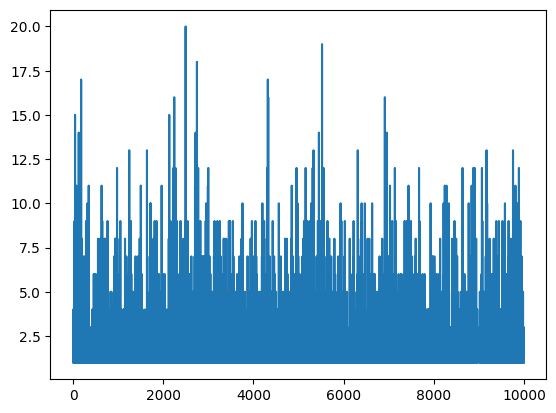

In [144]:
plt.plot(duracion_episodios);

In [145]:
entorno.display()

[['S' 'P' ' ' ' ' ' ']
 [' ' 'P' ' ' 'P' ' ']
 [' ' ' ' 'P' ' ' ' ']
 [' ' 'P' ' ' 'P' ' ']
 ['S' ' ' ' ' ' ' ' ']]


In [146]:
# Simulación sin aprender más:
# "TEST":
# Un episodio (o "juego")

entorno.reset()
agente.epsilon = 0
entorno.S = (2,1)
entorno.display()
print()

fin = False
while not fin:
  action = agente.choose_action(entorno.S)
  print("Acción elegida:", action)
  S_new, r, fin = entorno.step(action)
  entorno.display()
  print()

[['S' 'P' ' ' ' ' ' ']
 [' ' 'P' ' ' 'P' ' ']
 [' ' 'o' 'P' ' ' ' ']
 [' ' 'P' ' ' 'P' ' ']
 ['S' ' ' ' ' ' ' ' ']]

Acción elegida: left
[['S' 'P' ' ' ' ' ' ']
 [' ' 'P' ' ' 'P' ' ']
 ['o' ' ' 'P' ' ' ' ']
 [' ' 'P' ' ' 'P' ' ']
 ['S' ' ' ' ' ' ' ' ']]

Acción elegida: up
[['S' 'P' ' ' ' ' ' ']
 ['o' 'P' ' ' 'P' ' ']
 [' ' ' ' 'P' ' ' ' ']
 [' ' 'P' ' ' 'P' ' ']
 ['S' ' ' ' ' ' ' ' ']]

Acción elegida: up
[['S' 'P' ' ' ' ' ' ']
 [' ' 'P' ' ' 'P' ' ']
 [' ' ' ' 'P' ' ' ' ']
 [' ' 'P' ' ' 'P' ' ']
 ['S' ' ' ' ' ' ' ' ']]



In [148]:
agente.Q_table

left      right         up      down
(0, 0)  10.000000 -10.000000  10.000000  8.000000
(0, 1)   0.000000   0.000000   0.000000  0.000000
(0, 2)   0.000000   0.000000   0.000000  0.000000
(0, 3)   0.000000   0.000000   0.000000  0.000000
(0, 4)   0.000000   0.000000   0.000000  0.000000
(1, 0)   8.000000 -10.000000  10.000000  6.200000
(1, 1)   0.000000   0.000000   0.000000  0.000000
(1, 2)   0.000000   0.000000   0.000000  0.000000
(1, 3)   0.000000   0.000000   0.000000  0.000000
(1, 4)   0.000000   0.000000   0.000000  0.000000
(2, 0)   6.200000   4.579748   8.000000  7.999997
(2, 1)   6.199792  -9.996670  -9.999595 -9.999785
(2, 2)   0.000000   0.000000   0.000000  0.000000
(2, 3)   0.000000   0.000000   0.000000  0.000000
(2, 4)   0.000000   0.000000   0.000000  0.000000
(3, 0)   7.999930  -9.999986   6.199990  9.999998
(3, 1)   0.000000   0.000000   0.000000  0.000000
(3, 2)   0.000000   0.000000   0.000000  0.000000
(3, 3)   0.000000   0.000000   0.000000  0.000000
(3, 4)   0.000000   0.000000   0.000000  0.000000
(4, 0)   0.000000   0.000000   0.000000  0.000000
(4, 1)   0.000000   0.000000   0.000000  0.000000
(4, 2)   0.000000   0.000000   0.000000  0.000000
(4, 3)   0.000000   0.000000   0.000000  0.000000
(4, 4)   0.000000   0.000000   0.000000  0.000000